In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers import Input, Dense, Dropout
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.optimizers import Adamax
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [2]:

# Model fixed parameters
NInputs = 4 # Number of features (model inputs)
NOutputs = 3 # Number of targets (model outputs)



In [3]:

# Import training data (model inputs & outputs)
Feature_Train = pd.read_csv('processed_data/SL_Train_Features.csv', header = 0)
Feature_Train = Feature_Train[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Train = np.asarray(Feature_Train)
print(Feature_Train.shape)
Target_Train = pd.read_csv('processed_data/SL_Train_Target.csv', header = 0)
Target_Train = Target_Train[['SW', 'PHIF', 'VSH']]
Target_Train = np.asarray(Target_Train)
print(Target_Train.shape)
print(Feature_Train[0])


# Import validation data (model inputs & outputs)
Feature_Val = pd.read_csv('processed_data/SL_Val_Features.csv', header = 0)
Feature_Val = Feature_Val[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Val = np.asarray(Feature_Val)
print(Feature_Val.shape)
Target_Val = pd.read_csv('processed_data/SL_Val_Target.csv', header = 0)
Target_Val = Target_Val[['SW', 'PHIF', 'VSH']]
Target_Val = np.asarray(Target_Val)
print(Target_Val.shape)



# Import test data (model inputs & outputs)
Feature_Test = pd.read_csv('processed_data/SL_Test_Features.csv', header = 0)
Feature_Test = Feature_Test[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Test = np.asarray(Feature_Test)
print(Feature_Test.shape)
Target_Test = pd.read_csv('processed_data/SL_Test_Target.csv', header = 0)
Target_Test = Target_Test[['SW', 'PHIF', 'VSH']]
Target_Test = np.asarray(Target_Test)
print(Target_Test.shape)



(14061, 4)
(14061, 3)
[21.6229      2.288       0.1833     -0.45618019]
(6027, 4)
(6027, 3)
(8882, 4)
(8882, 3)


In [4]:
Feature_Test

array([[95.382     ,  2.565     ,  0.237     ,  0.29600667],
       [94.4       ,  2.565     ,  0.238     ,  0.29797924],
       [92.814     ,  2.568     ,  0.243     ,  0.29754167],
       ...,
       [27.965     ,  2.541     ,  0.104     ,  0.34654856],
       [12.617     ,  2.427     ,  0.114     ,  0.20411998],
       [12.828     ,  2.424     ,  0.106     ,  0.16643011]])

In [5]:
# Defining neural network

rate = 0.1

def nn():
    NN_ip = Input(shape=(NInputs,))
    x = Dense(1000)(NN_ip)
    x = PReLU()(x)
    x = Dropout(rate)(x)
    x = Dense(1000)(x)
    x = PReLU()(x)
    x = Dropout(rate)(x)
    NN_op = Dense(NOutputs)(x)
       
    NN_model = Model(NN_ip, NN_op)
    
    def loss_mse(true, pred):
        mean = pred[:, :NOutputs]
        return K.mean(K.square(true - mean), -1)

    def metric_mse(y_true, y_pred):
        mean = y_pred[:, :NOutputs]
        return K.mean(K.square(y_true - mean), -1)
    
    opt = Adamax(1e-3)
    
    NN_model.compile(loss = loss_mse, optimizer = opt, metrics = [metric_mse])
    
    return NN_model

NN = nn()
NN.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
p_re_lu (PReLU)              (None, 1000)              1000      
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 1000)              1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0     

Epoch 1/1000
9/9 [==============================] - 2s 189ms/step - loss: 0.0685 - metric_mse: 0.0685 - val_loss: 0.0160 - val_metric_mse: 0.0160
Epoch 2/1000
9/9 [==============================] - 1s 116ms/step - loss: 0.0199 - metric_mse: 0.0199 - val_loss: 0.0082 - val_metric_mse: 0.0082
Epoch 3/1000
9/9 [==============================] - 1s 117ms/step - loss: 0.0086 - metric_mse: 0.0086 - val_loss: 0.0061 - val_metric_mse: 0.0061
Epoch 4/1000
9/9 [==============================] - 1s 119ms/step - loss: 0.0070 - metric_mse: 0.0070 - val_loss: 0.0055 - val_metric_mse: 0.0055
Epoch 5/1000
9/9 [==============================] - 1s 122ms/step - loss: 0.0063 - metric_mse: 0.0063 - val_loss: 0.0050 - val_metric_mse: 0.0050
Epoch 6/1000
9/9 [==============================] - 1s 118ms/step - loss: 0.0060 - metric_mse: 0.0060 - val_loss: 0.0059 - val_metric_mse: 0.0059
Epoch 7/1000
9/9 [==============================] - 1s 122ms/step - loss: 0.0061 - metric_mse: 0.0061 - val_loss: 0.0047 - v

Epoch 57/1000
9/9 [==============================] - 1s 132ms/step - loss: 0.0045 - metric_mse: 0.0045 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 58/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0045 - metric_mse: 0.0045 - val_loss: 0.0041 - val_metric_mse: 0.0041
Epoch 59/1000
9/9 [==============================] - 1s 141ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0041 - val_metric_mse: 0.0041
Epoch 60/1000
9/9 [==============================] - 1s 132ms/step - loss: 0.0045 - metric_mse: 0.0045 - val_loss: 0.0042 - val_metric_mse: 0.0042
Epoch 61/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 62/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 63/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0

9/9 [==============================] - 1s 127ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0042 - val_metric_mse: 0.0042
Epoch 113/1000
9/9 [==============================] - 1s 125ms/step - loss: 0.0046 - metric_mse: 0.0046 - val_loss: 0.0041 - val_metric_mse: 0.0041
Epoch 114/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 115/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0044 - val_metric_mse: 0.0044
Epoch 116/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 117/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 118/1000
9/9 [==============================] - 1s 125ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0041 - va

9/9 [==============================] - 1s 163ms/step - loss: 0.0045 - metric_mse: 0.0045 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 168/1000
9/9 [==============================] - 1s 152ms/step - loss: 0.0042 - metric_mse: 0.0042 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 169/1000
9/9 [==============================] - 1s 158ms/step - loss: 0.0042 - metric_mse: 0.0042 - val_loss: 0.0042 - val_metric_mse: 0.0042
Epoch 170/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.0045 - metric_mse: 0.0045 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 171/1000
9/9 [==============================] - 1s 138ms/step - loss: 0.0044 - metric_mse: 0.0044 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 172/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0042 - metric_mse: 0.0042 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 173/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0041 - metric_mse: 0.0041 - val_loss: 0.0051 - va

9/9 [==============================] - 1s 148ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 223/1000
9/9 [==============================] - 1s 135ms/step - loss: 0.0042 - metric_mse: 0.0042 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 224/1000
9/9 [==============================] - 1s 134ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0037 - val_metric_mse: 0.0037
Epoch 225/1000
9/9 [==============================] - 1s 146ms/step - loss: 0.0041 - metric_mse: 0.0041 - val_loss: 0.0043 - val_metric_mse: 0.0043
Epoch 226/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0048 - metric_mse: 0.0048 - val_loss: 0.0037 - val_metric_mse: 0.0037
Epoch 227/1000
9/9 [==============================] - 1s 129ms/step - loss: 0.0041 - metric_mse: 0.0041 - val_loss: 0.0039 - val_metric_mse: 0.0039
Epoch 228/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0041 - metric_mse: 0.0041 - val_loss: 0.0044 - va

9/9 [==============================] - 1s 138ms/step - loss: 0.0039 - metric_mse: 0.0039 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 278/1000
9/9 [==============================] - 1s 141ms/step - loss: 0.0039 - metric_mse: 0.0039 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 279/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 280/1000
9/9 [==============================] - 1s 157ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 281/1000
9/9 [==============================] - 2s 178ms/step - loss: 0.0038 - metric_mse: 0.0038 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 282/1000
9/9 [==============================] - 1s 167ms/step - loss: 0.0038 - metric_mse: 0.0038 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 283/1000
9/9 [==============================] - 1s 162ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0054 - va

9/9 [==============================] - 1s 132ms/step - loss: 0.0041 - metric_mse: 0.0041 - val_loss: 0.0035 - val_metric_mse: 0.0035
Epoch 333/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0038 - metric_mse: 0.0038 - val_loss: 0.0035 - val_metric_mse: 0.0035
Epoch 334/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0040 - val_metric_mse: 0.0040
Epoch 335/1000
9/9 [==============================] - 1s 125ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0034 - val_metric_mse: 0.0034
Epoch 336/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0034 - val_metric_mse: 0.0034
Epoch 337/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0036 - metric_mse: 0.0036 - val_loss: 0.0033 - val_metric_mse: 0.0033
Epoch 338/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0033 - va

9/9 [==============================] - 1s 123ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0043 - val_metric_mse: 0.0043
Epoch 388/1000
9/9 [==============================] - 1s 121ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0045 - val_metric_mse: 0.0045
Epoch 389/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0040 - metric_mse: 0.0040 - val_loss: 0.0045 - val_metric_mse: 0.0045
Epoch 390/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.0039 - metric_mse: 0.0039 - val_loss: 0.0036 - val_metric_mse: 0.0036
Epoch 391/1000
9/9 [==============================] - 1s 122ms/step - loss: 0.0036 - metric_mse: 0.0036 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 392/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0033 - val_metric_mse: 0.0033
Epoch 393/1000
9/9 [==============================] - 1s 129ms/step - loss: 0.0034 - metric_mse: 0.0034 - val_loss: 0.0036 - va

9/9 [==============================] - 1s 124ms/step - loss: 0.0039 - metric_mse: 0.0039 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 443/1000
9/9 [==============================] - 1s 126ms/step - loss: 0.0035 - metric_mse: 0.0035 - val_loss: 0.0038 - val_metric_mse: 0.0038
Epoch 444/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0034 - metric_mse: 0.0034 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 445/1000
9/9 [==============================] - 1s 132ms/step - loss: 0.0034 - metric_mse: 0.0034 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 446/1000
9/9 [==============================] - 1s 140ms/step - loss: 0.0032 - metric_mse: 0.0032 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 447/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0032 - metric_mse: 0.0032 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 448/1000
9/9 [==============================] - 1s 149ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0030 - va

9/9 [==============================] - 1s 131ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0031 - val_metric_mse: 0.0031
Epoch 498/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0032 - metric_mse: 0.0032 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 499/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 500/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0035 - metric_mse: 0.0035 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 501/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 502/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0029 - val_metric_mse: 0.0029
Epoch 503/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0032 - va

9/9 [==============================] - 1s 130ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0031 - val_metric_mse: 0.0031
Epoch 553/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0045 - val_metric_mse: 0.0045
Epoch 554/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0037 - metric_mse: 0.0037 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 555/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0031 - val_metric_mse: 0.0031
Epoch 556/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 557/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 558/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0028 - metric_mse: 0.0028 - val_loss: 0.0028 - va

9/9 [==============================] - 1s 120ms/step - loss: 0.0028 - metric_mse: 0.0028 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 608/1000
9/9 [==============================] - 1s 123ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 609/1000
9/9 [==============================] - 1s 123ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0025 - val_metric_mse: 0.0025
Epoch 610/1000
9/9 [==============================] - 1s 123ms/step - loss: 0.0028 - metric_mse: 0.0028 - val_loss: 0.0029 - val_metric_mse: 0.0029
Epoch 611/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0027 - val_metric_mse: 0.0027
Epoch 612/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 613/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0025 - va

9/9 [==============================] - 1s 129ms/step - loss: 0.0026 - metric_mse: 0.0026 - val_loss: 0.0025 - val_metric_mse: 0.0025
Epoch 663/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0029 - val_metric_mse: 0.0029
Epoch 664/1000
9/9 [==============================] - 1s 129ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0027 - val_metric_mse: 0.0027
Epoch 665/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 666/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0026 - val_metric_mse: 0.0026
Epoch 667/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0023 - val_metric_mse: 0.0023
Epoch 668/1000
9/9 [==============================] - 1s 149ms/step - loss: 0.0026 - metric_mse: 0.0026 - val_loss: 0.0023 - va

9/9 [==============================] - 1s 129ms/step - loss: 0.0026 - metric_mse: 0.0026 - val_loss: 0.0024 - val_metric_mse: 0.0024
Epoch 718/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0029 - val_metric_mse: 0.0029
Epoch 719/1000
9/9 [==============================] - 1s 135ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0033 - val_metric_mse: 0.0033
Epoch 720/1000
9/9 [==============================] - 1s 142ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 721/1000
9/9 [==============================] - 2s 174ms/step - loss: 0.0029 - metric_mse: 0.0029 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 722/1000
9/9 [==============================] - 1s 143ms/step - loss: 0.0026 - metric_mse: 0.0026 - val_loss: 0.0033 - val_metric_mse: 0.0033
Epoch 723/1000
9/9 [==============================] - 1s 132ms/step - loss: 0.0030 - metric_mse: 0.0030 - val_loss: 0.0024 - va

9/9 [==============================] - 1s 130ms/step - loss: 0.0025 - metric_mse: 0.0025 - val_loss: 0.0022 - val_metric_mse: 0.0022
Epoch 773/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0024 - val_metric_mse: 0.0024
Epoch 774/1000
9/9 [==============================] - 1s 132ms/step - loss: 0.0025 - metric_mse: 0.0025 - val_loss: 0.0025 - val_metric_mse: 0.0025
Epoch 775/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0022 - val_metric_mse: 0.0022
Epoch 776/1000
9/9 [==============================] - 1s 148ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0021 - val_metric_mse: 0.0021
Epoch 777/1000
9/9 [==============================] - 1s 151ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0021 - val_metric_mse: 0.0021
Epoch 778/1000
9/9 [==============================] - 2s 166ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0032 - va

9/9 [==============================] - 1s 123ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0030 - val_metric_mse: 0.0030
Epoch 828/1000
9/9 [==============================] - 1s 121ms/step - loss: 0.0031 - metric_mse: 0.0031 - val_loss: 0.0046 - val_metric_mse: 0.0046
Epoch 829/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0036 - metric_mse: 0.0036 - val_loss: 0.0024 - val_metric_mse: 0.0024
Epoch 830/1000
9/9 [==============================] - 1s 124ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0021 - val_metric_mse: 0.0021
Epoch 831/1000
9/9 [==============================] - 1s 130ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0025 - val_metric_mse: 0.0025
Epoch 832/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0026 - metric_mse: 0.0026 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 833/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0027 - metric_mse: 0.0027 - val_loss: 0.0023 - va

9/9 [==============================] - 1s 144ms/step - loss: 0.0025 - metric_mse: 0.0025 - val_loss: 0.0023 - val_metric_mse: 0.0023
Epoch 883/1000
9/9 [==============================] - 1s 138ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0022 - val_metric_mse: 0.0022
Epoch 884/1000
9/9 [==============================] - 1s 125ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0023 - val_metric_mse: 0.0023
Epoch 885/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0028 - val_metric_mse: 0.0028
Epoch 886/1000
9/9 [==============================] - 1s 139ms/step - loss: 0.0038 - metric_mse: 0.0038 - val_loss: 0.0023 - val_metric_mse: 0.0023
Epoch 887/1000
9/9 [==============================] - 1s 134ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0022 - val_metric_mse: 0.0022
Epoch 888/1000
9/9 [==============================] - 1s 165ms/step - loss: 0.0024 - metric_mse: 0.0024 - val_loss: 0.0024 - va

9/9 [==============================] - 1s 125ms/step - loss: 0.0021 - metric_mse: 0.0021 - val_loss: 0.0019 - val_metric_mse: 0.0019
Epoch 938/1000
9/9 [==============================] - 1s 125ms/step - loss: 0.0021 - metric_mse: 0.0021 - val_loss: 0.0020 - val_metric_mse: 0.0020
Epoch 939/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0022 - metric_mse: 0.0022 - val_loss: 0.0020 - val_metric_mse: 0.0020
Epoch 940/1000
9/9 [==============================] - 1s 128ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0022 - val_metric_mse: 0.0022
Epoch 941/1000
9/9 [==============================] - 1s 129ms/step - loss: 0.0022 - metric_mse: 0.0022 - val_loss: 0.0021 - val_metric_mse: 0.0021
Epoch 942/1000
9/9 [==============================] - 1s 145ms/step - loss: 0.0022 - metric_mse: 0.0022 - val_loss: 0.0023 - val_metric_mse: 0.0023
Epoch 943/1000
9/9 [==============================] - 1s 127ms/step - loss: 0.0025 - metric_mse: 0.0025 - val_loss: 0.0020 - va

9/9 [==============================] - 1s 142ms/step - loss: 0.0021 - metric_mse: 0.0021 - val_loss: 0.0025 - val_metric_mse: 0.0025
Epoch 993/1000
9/9 [==============================] - 1s 147ms/step - loss: 0.0028 - metric_mse: 0.0028 - val_loss: 0.0018 - val_metric_mse: 0.0018
Epoch 994/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.0023 - metric_mse: 0.0023 - val_loss: 0.0019 - val_metric_mse: 0.0019
Epoch 995/1000
9/9 [==============================] - 1s 144ms/step - loss: 0.0021 - metric_mse: 0.0021 - val_loss: 0.0018 - val_metric_mse: 0.0018
Epoch 996/1000
9/9 [==============================] - 1s 149ms/step - loss: 0.0020 - metric_mse: 0.0020 - val_loss: 0.0018 - val_metric_mse: 0.0018
Epoch 997/1000
9/9 [==============================] - 1s 131ms/step - loss: 0.0020 - metric_mse: 0.0020 - val_loss: 0.0018 - val_metric_mse: 0.0018
Epoch 998/1000
9/9 [==============================] - 1s 136ms/step - loss: 0.0020 - metric_mse: 0.0020 - val_loss: 0.0020 - va

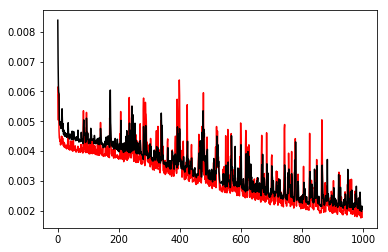

In [6]:
NN = nn()
NN.load_weights('NNWeights.h5')

history = NN.fit(Feature_Train, Target_Train, 
                     epochs = 1000, 
                     batch_size = int(Feature_Train.shape[0]/8), 
                     shuffle = True, 
                     validation_data = (Feature_Val, Target_Val))
    
plt.plot(history.history['val_loss'][2:],'r')
plt.plot(history.history['loss'][2:],'k')


In [13]:
#3.1 Plot the predicted saturation versus the Interpreted saturation
PredictedTarget = NN.predict(Feature_Test)
[PredictedSw, PredictedPHIF, PredictedVSH] = [PredictedTarget[:,0], PredictedTarget[:,1], PredictedTarget[:,2]]


In [14]:
PredictedTarget

array([[1.0030622 , 0.07317542, 0.76607037],
       [0.99900687, 0.07356475, 0.75777173],
       [0.9953767 , 0.07372031, 0.74499446],
       ...,
       [0.9208472 , 0.0631877 , 0.17587958],
       [0.7344154 , 0.1420855 , 0.06964283],
       [0.76511383, 0.14285654, 0.06897266]], dtype=float32)

In [15]:
PredictedTarget.shape
Target_Test.shape

(8882, 3)

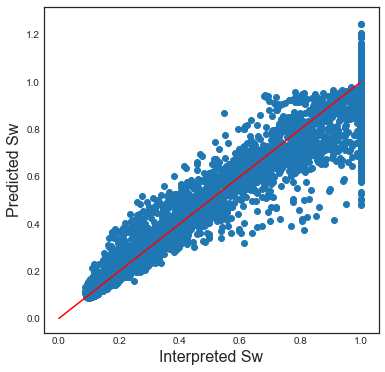

In [16]:
plt.figure(figsize = (6,6))
plt.style.use('seaborn-white')
plt.scatter(Target_Test[:,0], PredictedSw)
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), color = 'r', alpha = 1)
plt.xlabel('Interpreted Sw', FontSize = 16)
plt.ylabel('Predicted Sw', FontSize = 16)
plt.show()


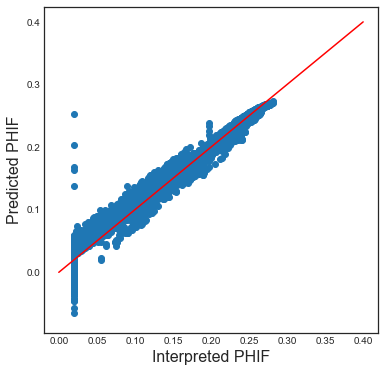

In [17]:
plt.figure(figsize = (6,6))
plt.style.use('seaborn-white')
plt.scatter(Target_Test[:,1], PredictedPHIF)
plt.plot(np.linspace(0, .4, 2), np.linspace(0, .4, 2), color = 'r', alpha = 1)
plt.xlabel('Interpreted PHIF', FontSize = 16)
plt.ylabel('Predicted PHIF', FontSize = 16)
plt.show()


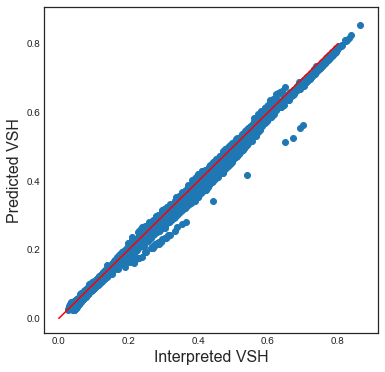

In [18]:
plt.figure(figsize = (6,6))
plt.style.use('seaborn-white')
plt.scatter(Target_Test[:,2], PredictedVSH)
plt.plot(np.linspace(0, .8, 2), np.linspace(0, .8, 2), color = 'r', alpha = 1)
plt.xlabel('Interpreted VSH', FontSize = 16)
plt.ylabel('Predicted VSH', FontSize = 16)
plt.show()

In [ ]:
output_df = pd.read_csv('processed_data/SL_Test_Target.csv', header = 0)
type(output_df)
output_df.insert( 4,"PredictedSw", PredictedSw)
output_df.insert( 6,"PredictedVSH", PredictedVSH)
output_df.insert( 8,"PredictedPHIF", PredictedPHIF)
output_df
output_df.to_csv('processed_data/SL_PredictedProperties.csv', index=True)


In [ ]:
output_df['VSHDifference'] = abs(output_df['PredictedVSH'] - output_df['VSH'])
output_df['PHIFDifference'] = abs(output_df['PredictedPHIF'] - output_df['PHIF'])
output_df['SwDifference'] = abs(output_df['PredictedSw'] - output_df['SW'])

## Plotting the Prediction Results
After the prediction has completed, we can view the predicted result against the actual measurement on the test well: 15/9-F-11 B

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1.plot(output_df['MD'], output_df['VSH'], label='Interpreted', color='black')
ax1.plot(output_df['MD'], output_df['PredictedVSH'], label='Predicted', color='red')

ax1.set_ylabel('VSH', fontsize=16, fontweight='bold', labelpad=30)
ax1.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
ax1.tick_params(which='both', labelsize=14)


ax2.plot(output_df['MD'], output_df['VSHDifference'], label='Interpreted', color='black')
ax2.set_ylim(0,1)

ax2.set_ylabel('Abs. Prediction Difference', fontsize=16, fontweight='bold', labelpad=30)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
    ax.tick_params(which='both', labelsize=14)

ax1.legend(fontsize=14, facecolor='white', frameon=True)

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1.plot(output_df['MD'], output_df['PHIF'], label='Interpreted', color='black')
ax1.plot(output_df['MD'], output_df['PredictedPHIF'], label='Predicted', color='red')

ax1.set_ylabel('PHIF', fontsize=16, fontweight='bold', labelpad=30)
ax1.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
ax1.tick_params(which='both', labelsize=14)


ax2.plot(output_df['MD'], output_df['PHIFDifference'], label='Interpreted', color='black')
ax2.set_ylim(0,1)

ax2.set_ylabel('Abs. Prediction Difference', fontsize=16, fontweight='bold', labelpad=30)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
    ax.tick_params(which='both', labelsize=14)

ax1.legend(fontsize=14, facecolor='white', frameon=True)

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1.plot(output_df['MD'], output_df['SW'], label='Interpreted', color='black')
ax1.plot(output_df['MD'], output_df['PredictedSw'], label='Predicted', color='red')

ax1.set_ylabel('Water Saturation (dec)', fontsize=16, fontweight='bold', labelpad=30)
ax1.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
ax1.tick_params(which='both', labelsize=14)


ax2.plot(output_df['MD'], output_df['SwDifference'], label='Interpreted', color='black')
ax2.set_ylim(0,1)

ax2.set_ylabel('Abs. Prediction Difference', fontsize=16, fontweight='bold', labelpad=30)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
    ax.tick_params(which='both', labelsize=14)

ax1.legend(fontsize=14, facecolor='white', frameon=True)
